<div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 40px; margin-top: 0;">
    <div style="flex: 0 0 auto; margin-left: 0; margin-bottom: 0; margin-top: 0;">
        <img src="./pics/UCSD Logo.png" alt="UCSD Logo" style="width: 179px; margin-bottom: 0px; margin-top: 20px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/sdsc-logo.png" alt="SDSC Logo" style="width: 300px; margin-bottom: 0px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/usda-logo.png" alt="USDA Logo" style="width: 100px; margin-bottom: 0px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/wstc-logo.png" alt="WSTC Logo" style="width: 100px; height: 100px; margin-bottom: 0px;">
    </div>
</div>

<h1 style="text-align: center; font-size: 48px; margin-top: 0;">Rangeland Analysis Platform</h1>

- **Team Name: Dry-shRub**
- **Team Members:**
    - Uzair Gheewala
    - Sean Harmon

1. In the `RAP.ipynb` notebook, we previously selected the 2025 RAP tile at list index 35 as a quick example. That selection was arbitrary and only served to demonstrate how to access RAP vegetation-cover data in California.

For this Data Challenge, you will work with data located from [D. L. Bliss State Park](https://en.wikipedia.org/wiki/D._L._Bliss_State_Park), one of our areas of interest (AOI). Use RAP data in Google Earth Engine to identify and select a 2025 RAP vegetation-cover tile whose footprint intersects D. L. Bliss.

Use the following bounding box (WGS84 lon/lat) to define the AOI:

* Min X (lon): -120.1018846
* Min Y (lat): 38.99274873
* Max X (lon): -120.0899834
* Max Y (lat): 39.0020357

In [22]:
import ee
import geemap
import folium
import numpy as np
import matplotlib.pyplot as plt

In [23]:
ee.Authenticate()
ee.Initialize(project="shrubwise-dc-488219")
RAP_veg_yearly_10m = ee.ImageCollection("projects/rap-data-365417/assets/vegetation-cover-10m")

In [24]:
aoi = ee.Geometry.Rectangle(
    [-120.1018846, 38.99274873, -120.0899834, 39.0020357],
    geodesic=False
)

In [32]:
images_2025 = RAP_veg_yearly_10m.filter(ee.Filter.eq("year", 2025))
hits = images_2025.filterBounds(aoi)

print("2025 images total:", images_2025.size().getInfo())
print("2025 images intersecting AOI:", hits.size().getInfo())

hit_ids = hits.aggregate_array("system:index").getInfo()
print("Intersecting tile IDs:")
for i, tid in enumerate(hit_ids):
    print(i, tid)

2025 images total: 1075
2025 images intersecting AOI: 2
Intersecting tile IDs:
0 2025-10-725000-4300000
1 2025-11-200000-4300000


In [33]:
# Select best tile: largest intersection area with AOI

def add_intersection_area(img):
    inter = img.geometry().intersection(aoi, ee.ErrorMargin(1))
    return img.set("aoi_intersection_area_m2", inter.area(1))

hits_ranked = hits.map(add_intersection_area).sort("aoi_intersection_area_m2", False)
tile = ee.Image(hits_ranked.first())

tile_id = tile.get("system:index").getInfo()
inter_area = tile.get("aoi_intersection_area_m2").getInfo()

print("Selected tile:", tile_id)
print("AOI * tile area (m^2):", inter_area)

Selected tile: 2025-10-725000-4300000
AOI * tile area (m^2): 1062072.8824208865


2. Using the DL Bliss tile, visualize RAP **shrub cover** .

In [34]:
shrub = tile.select("SHR").rename("shrub_cover")

In [35]:
vis = {"min": 0, "max": 100, "palette": ["ffffff","c7e9c0","74c476","238b45","00441b"]}
map_id = shrub.getMapId(vis)

center_lat = (38.99274873 + 39.0020357) / 2
center_lon = (-120.1018846 + -120.0899834) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

folium.TileLayer(
    tiles=map_id["tile_fetcher"].url_format,
    attr="Google Earth Engine",
    name="RAP Shrub Cover 2025",
    overlay=True
).add_to(m)

# outline AOI
folium.GeoJson(
    data=aoi.getInfo(),
    name="AOI (DL Bliss)",
).add_to(m)

folium.LayerControl().add_to(m)
m

3. Compute and plot a histogram and basic summary statistics (mean, median, min, max) for a 5km x 5km area of shrub cover within your selected tile.

In [36]:
center_lat = (38.99274873 + 39.0020357) / 2
center_lon = (-120.1018846 + -120.0899834) / 2

center_pt = ee.Geometry.Point([center_lon, center_lat])
roi_5km = center_pt.buffer(2500).bounds()   # 2500m radius -> 5km bounding square

In [37]:
stats_reducer = (
    ee.Reducer.count()
      .combine(ee.Reducer.mean(), sharedInputs=True)
      .combine(ee.Reducer.median(), sharedInputs=True)
      .combine(ee.Reducer.min(), sharedInputs=True)
      .combine(ee.Reducer.max(), sharedInputs=True)
      .combine(ee.Reducer.stdDev(), sharedInputs=True)
      .combine(ee.Reducer.percentile([5, 25, 75, 95]), sharedInputs=True)
)

stats = shrub.reduceRegion(
    reducer=stats_reducer,
    geometry=roi_5km,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
).getInfo()

# % shrub > 0
pct_gt0 = shrub.gt(0).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi_5km,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
).get("shrub_cover").getInfo()

# % shrub >= 5
pct_ge5 = shrub.gte(5).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi_5km,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
).get("shrub_cover").getInfo()

# Mean shrub cover among NONZERO pixels 
nonzero = shrub.updateMask(shrub.gt(0))
nz_stats = nonzero.reduceRegion(
    reducer=ee.Reducer.mean().combine(ee.Reducer.count(), sharedInputs=True),
    geometry=roi_5km,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
).getInfo()

report = {
    "tile_id": tile_id,
    "valid_pixel_count": stats.get("shrub_cover_count"),
    "mean": stats.get("shrub_cover_mean"),
    "median": stats.get("shrub_cover_median"),
    "min": stats.get("shrub_cover_min"),
    "max": stats.get("shrub_cover_max"),
    "stdDev": stats.get("shrub_cover_stdDev"),
    "p05": stats.get("shrub_cover_p5"),
    "p25": stats.get("shrub_cover_p25"),
    "p75": stats.get("shrub_cover_p75"),
    "p95": stats.get("shrub_cover_p95"),
    "pct_shrub_gt0": float(pct_gt0) if pct_gt0 is not None else None,
    "pct_shrub_ge5": float(pct_ge5) if pct_ge5 is not None else None,
    "nonzero_mean": nz_stats.get("shrub_cover_mean"),
    "nonzero_count": nz_stats.get("shrub_cover_count"),
}

print("EE RAP shrub summary (5km x 5km):")
for k, v in report.items():
    print(f"  {k}: {v}")

EE RAP shrub summary (5km x 5km):
  tile_id: 2025-10-725000-4300000
  valid_pixel_count: 249964
  mean: 2.6141136269103664
  median: 0
  min: 0
  max: 68
  stdDev: 4.6283284905165045
  p05: 0
  p25: 0
  p75: 4
  p95: 10.999999999999986
  pct_shrub_gt0: 0.39082352388318975
  pct_shrub_ge5: 0.2400666738352866
  nonzero_mean: 6.688731530120687
  nonzero_count: 97714


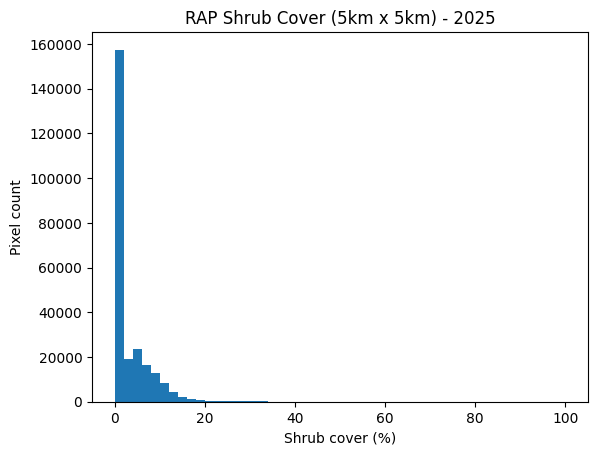

In [38]:
hist = shrub.reduceRegion(
    reducer=ee.Reducer.fixedHistogram(0, 100, 50),
    geometry=roi_5km,
    scale=10,
    maxPixels=1e9,
    bestEffort=True
).get("shrub_cover").getInfo()

# hist is [[bin_left_edge, count], ...]
bin_left = np.array([b[0] for b in hist], dtype=float)
counts = np.array([b[1] for b in hist], dtype=float)
bin_width = 100 / 50
bin_centers = bin_left + bin_width / 2

plt.figure()
plt.bar(bin_centers, counts, width=bin_width)
plt.title("RAP Shrub Cover (5km x 5km) - 2025")
plt.xlabel("Shrub cover (%)")
plt.ylabel("Pixel count")
plt.show()